# Multi-label prediction with Planet Amazon dataset

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

# Getting the data

Download planet dataset from [Kaggle API](https://github.com/Kaggle/kaggle-api).

First, install the Kaggle API by uncommenting the following line.

In [3]:
# ! {sys.executable} -m pip install kaggle --upgrade

Upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [4]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
! mkdir %userprofile%\.kaggle
! move kaggle.json %userprofile%\.kaggle

A subdirectory or file C:\Users\Ruchika\.kaggle already exists.
The system cannot find the file specified.


You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). 

You first need to go to its main page and accept its rules, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a 403 forbidden error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on Rules tab, and then scroll to the bottom to find the accept button).

In [5]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

WindowsPath('C:/Users/Ruchika/.fastai/data/planet')

In [6]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run sudo apt install p7zip-full in your terminal).

In [7]:
# ! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [8]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

# Multiclassification

Each picture of the dataset obtained from 
[planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space) can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [9]:
path = 'D:/Fastai/data/planet'
df = pd.read_csv('D:/Fastai/data/planet/train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a DataBunch while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using ImageList (and not ImageDataBunch). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [10]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\'.

In [11]:
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [12]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

show_batch still works, and show us the different labels separated by ;.

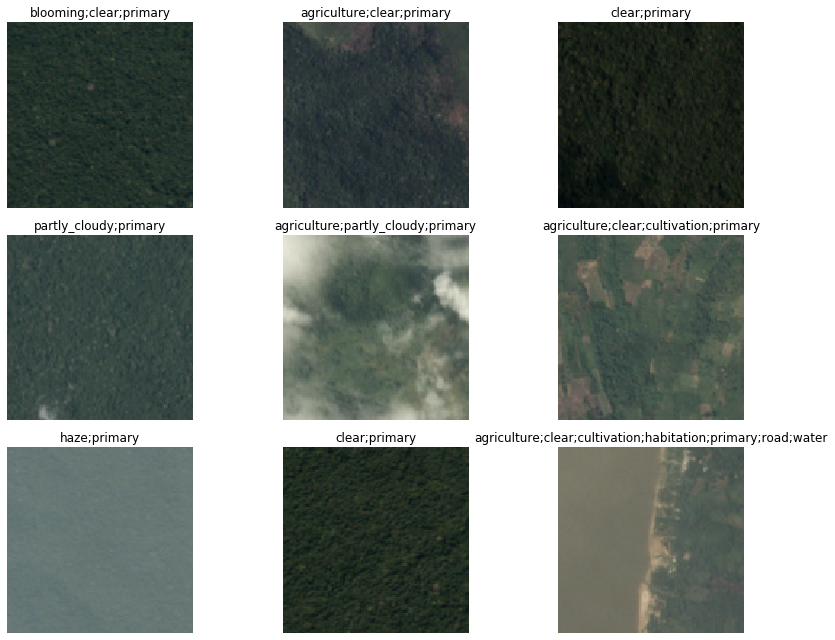

In [13]:
data.show_batch(rows=3, figsize=(12,9))

In [14]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

We will train a resnet50 framework, but we will use accuracy_thresh instead of accuracy in this code.

In [Pet_breed_classifier](https://github.com/ruchikaverma-iitg/Hands-on-Deep-Learning/blob/master/Pet_breed_classification.ipynb), we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. accuracy_thresh selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [15]:
arch = models.resnet50

In [16]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

We use the LR Finder to pick a good learning rate.

In [17]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


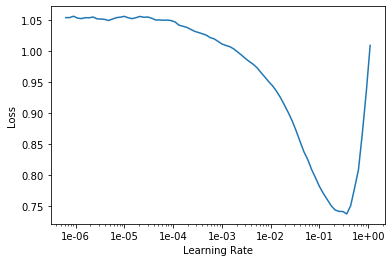

In [18]:
learn.recorder.plot()

Then we can fit the head of our network.

In [19]:
lr = 0.01

In [20]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.139359,0.117225,0.949366,0.896259,05:11
1,0.112208,0.097198,0.952527,0.913774,05:23
2,0.102373,0.091955,0.956981,0.918602,06:03
3,0.096618,0.086961,0.956952,0.924880,05:53
4,0.093676,0.085512,0.956349,0.925738,05:43


In [22]:
interp = ClassificationInterpretation.from_learner(learn)

In [24]:
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

False

In [33]:
print(data.valid_ds.classes)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


# Prediction using trained model

In [38]:
preds, _ = learn.get_preds(ds_type=data.valid_ds)

In [42]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [52]:
kk = 10
labelled_preds[:kk]

['clear haze primary',
 'agriculture clear cultivation primary road water',
 'clear primary',
 'agriculture clear habitation primary road',
 'agriculture haze primary road water',
 'agriculture clear cultivation primary water',
 'cloudy haze primary',
 'agriculture clear cultivation primary',
 'agriculture clear cultivation primary road water',
 'partly_cloudy primary']

In [64]:
true_labels = [data.valid_ds.y[j] for j in range(kk)]
true_labels


[MultiCategory agriculture;partly_cloudy;primary;water,
 MultiCategory partly_cloudy;primary,
 MultiCategory clear;primary,
 MultiCategory agriculture;partly_cloudy;primary,
 MultiCategory clear;cultivation;primary;water,
 MultiCategory cloudy,
 MultiCategory clear;primary,
 MultiCategory partly_cloudy;primary,
 MultiCategory cloudy,
 MultiCategory clear;primary]

In [65]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [66]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


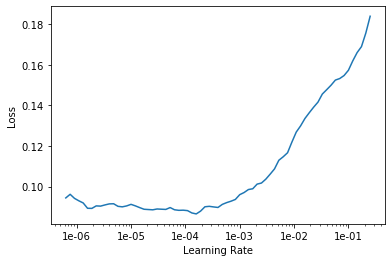

In [67]:
learn.lr_find()
learn.recorder.plot()

In [68]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.099778,0.092753,0.954743,0.920477,06:37
1,0.098883,0.090454,0.951539,0.920753,07:03
2,0.091948,0.085340,0.958856,0.924726,07:20
3,0.082931,0.081775,0.958842,0.927923,07:41
4,0.081827,0.080994,0.958725,0.928041,07:24


Instead of transforming the image to 128, we can look at better resolution of the image by looking at 256 size image to get better training.

In [69]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [71]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

lr=1e-2/2
learn.fit_one_cycle(5, slice(lr))
learn.save('stage-1-256-rn50')

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))
learn.recorder.plot_losses()
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of 0.930.

In [ ]:
learn.export()